In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn import metrics
import scipy.stats as stats
import os
import calendar
from datetime import datetime
import collections

sns.set_style('darkgrid')
sns.set(font_scale=1.5)

# Data Loading

In [2]:
videos_df = pd.read_pickle('US_trending.pkl')

# filtriranje datuma do 1.4.2020. (korona)
videos_df = videos_df[videos_df['trending_date'] < datetime(2020, 4, 1)]

In [3]:
videos_df.head()

video_id                                              title  \
0  vPx6M7eTYbc     Spill Your Guts: Harry Styles & Kendall Jenner   
1  sg8WaeeFyNY                           WE GOT UNEXPECTED NEWS..   
2  q1PR05q8l2g                    Last To Miss Layup Wins $10,000   
3  t6Z6RIXq0L0  LAKERS at MAGIC | FULL GAME HIGHLIGHTS | Decem...   
4  TGDpRB4ovvA  TIPPING DRIVE-THRU WORKERS $100 FOR THE HOLIDA...   

         published_at                channel_id  \
0 2019-12-11 07:08:34  UCJ0uqCI0Vqr2Rrt1HseGirg   
1 2019-12-12 05:25:42  UCDSJCBYqL7VQrlXfhr1RtwA   
2 2019-12-11 23:00:53  UCQIUhhcmXsu6cN6n3y9-Pww   
3 2019-12-12 02:35:33  UCWJ2lWNubArHWmf3FIHbfcQ   
4 2019-12-12 02:38:37  UCtj45MepAoKxZoyR_Mnt86Q   

                          channel_title  category_id trending_date  \
0  The Late Late Show with James Corden           24    2019-12-12   
1                         Les Do Makeup           26    2019-12-12   
2                                Jesser           17    2019-12-12   
3                                   NBA           17    2019-12-12   
4                          Royal Family           24    2019-12-12   

                                                tags  view_count   likes  ...  \
0  The Late Late Show|Late Late Show|James Corden...    11636632  571835  ...   
1                                             [none]      423215   52780  ...   
2  last to leave|nba basketball|nba basketball hi...      463685   20178  ...   
3  sp:ty=high|sp:dt=2019-12-12T00:00:00Z|sp:st=ba...      659579    4605  ...   
4  queen Naija|Medicine|Queen|Spicy|Royalty Squad...      175558   18400  ...   

   days_in_trending   category_name publish_to_trend  publishing_hour  \
0                 1   Entertainment                1                7   
1                 7  How-to & Style                0                5   
2                 7           Sport                1               23   
3                 2           Sport                0                2   
4                 6   Entertainment                0                2   

   publishing_day disc_likes  positive_sentiment negative_sentiment  \
0       Wednesday        3.0            0.468750           0.131250   
1        Thursday        3.0            0.750000           0.075000   
2       Wednesday        2.0            0.318182           0.181818   
3        Thursday        1.0            0.462069           0.193103   
4        Thursday        2.0            0.631250           0.131250   

   neutral_sentiment  analyzed_comments  
0           0.400000              160.0  
1           0.175000               40.0  
2           0.500000               88.0  
3           0.344828              145.0  
4           0.237500              160.0  

[5 rows x 26 columns]

## Dealing with missing values

In [4]:
# ovde mozda razmisliti o necemu boljem (srednja vrednost po kategoriji i slicno)
videos_df['positive_sentiment'] = videos_df['positive_sentiment'].fillna(videos_df['positive_sentiment'].mean())
videos_df['negative_sentiment'] = videos_df['negative_sentiment'].fillna(videos_df['negative_sentiment'].mean())
videos_df['neutral_sentiment'] = videos_df['neutral_sentiment'].fillna(videos_df['neutral_sentiment'].mean())
videos_df.isna().sum()

video_id               0
title                  0
published_at           0
channel_id             0
channel_title          0
category_id            0
trending_date          0
tags                   0
view_count             0
likes                  0
dislikes               0
comment_count          0
thumbnail_link         0
comments_disabled      0
ratings_disabled       0
description           20
days_in_trending       0
category_name          0
publish_to_trend       0
publishing_hour        0
publishing_day         0
disc_likes             0
positive_sentiment     0
negative_sentiment     0
neutral_sentiment      0
analyzed_comments      0
dtype: int64

### X and y arrays

In [5]:
set(videos_df['category_name'])  # provera, ovde se desavala glupost kad se eksportuje u CSV

{'Autos & Vehicles',
 'Comedy',
 'Education',
 'Entertainment',
 'Film & Animation',
 'Gaming',
 'How-to & Style',
 'Music',
 'News & Politics',
 'Non-profits & Activism',
 'People & Blogs',
 'Pets & Animals',
 'Science & Technology',
 'Sport',
 'Travel & Events'}

In [6]:
X = videos_df[['view_count', 'dislikes', 'comment_count', 'positive_sentiment', 'negative_sentiment', 'category_id']]
y = videos_df['likes']

### One Hot Encoding for category feature

In [7]:
#category_dummies = pd.get_dummies(videos_df['category_name'])
#X = pd.concat([X, category_dummies], axis=1)
#X.head()

onehotencoder = OneHotEncoder(categorical_features = [5]) 
X = onehotencoder.fit_transform(X).toarray() 
X.size

C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


81920

### Split data into training and test sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

### Feature Scaling

In [9]:
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

#scaler_y = MinMaxScaler()
#y_train = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1))
#y_test = scaler_y.transform(np.array(y_test).reshape(-1, 1))

# Linear regression

In [10]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [11]:
print(lin_reg.score(X_test, y_test))

0.7604674474865991


Text(0, 0.5, 'Predicted Y')

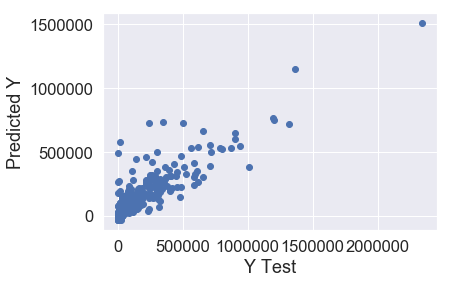

In [12]:
plt.scatter(y_test, y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [13]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
scatter_index = rmse / np.mean(y)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Scatter Index (normalized RMSE): ', scatter_index)    # ako je manji od 1 => model je dobar
print('R squared on training set: ', lin_reg.score(X_train, y_train))
print('R squared on test set: ', lin_reg.score(X_test, y_test))

MAE: 33064.10496338487
MSE: 5371142252.7542715
RMSE: 73288.07715279663
Scatter Index (normalized RMSE):  0.9876098651634929
R squared on training set:  0.8500958599972295
R squared on test set:  0.7604674474865991


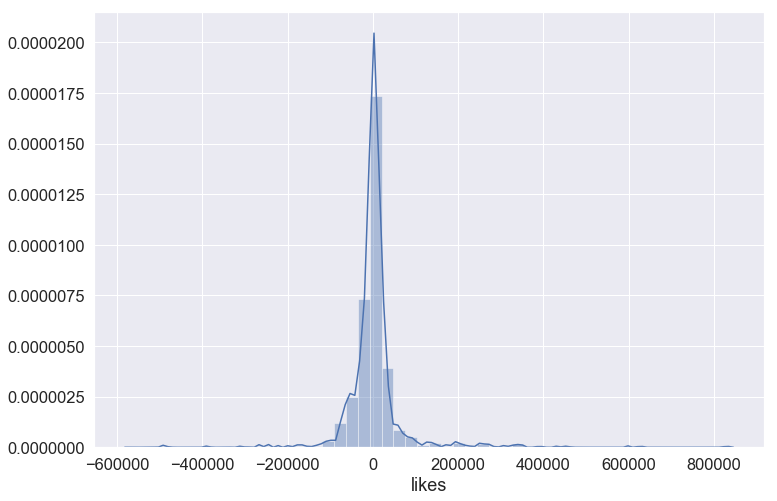

In [14]:
# residual histogram
plt.figure(figsize=(12, 8))
sns.distplot((y_test-y_pred), bins=50);

# Napomena: Rigde i GradientBoosting ce verovatno bolje raditi kad bude vise feature-a

# Ridge regression with Grid Search

In [15]:
ridge_reg = Ridge(solver='cholesky')

In [16]:
print('Optimizing parameters of ridge regression...')
print('start at: {}'.format(datetime.now().time()))

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
ridge_regressor = GridSearchCV(estimator=ridge_reg, param_grid=parameters, cv=5)
ridge_regressor.fit(X_train, y_train)

print('stop at: {}'.format(datetime.now().time()))
print('---------------------------------')

print(ridge_regressor.best_score_)
print(ridge_regressor.best_estimator_)

Optimizing parameters of ridge regression...
start at: 16:59:18.815333
stop at: 16:59:18.919115
---------------------------------
0.6894481276311677
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='cholesky', tol=0.001)


C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.07037e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3548e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [17]:
y_pred = ridge_regressor.predict(X_test)

Text(0, 0.5, 'Predicted Y')

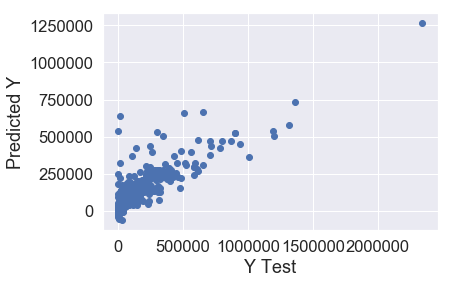

In [18]:
plt.scatter(y_test, y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [19]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared on training set: ', ridge_regressor.score(X_train, y_train))
print('R squared on test set: ', ridge_regressor.score(X_test, y_test))

MAE: 38601.92769149468
MSE: 7348446652.458848
RMSE: 85723.0812118816
R squared on training set:  0.7613414240284329
R squared on test set:  0.6722871782497635


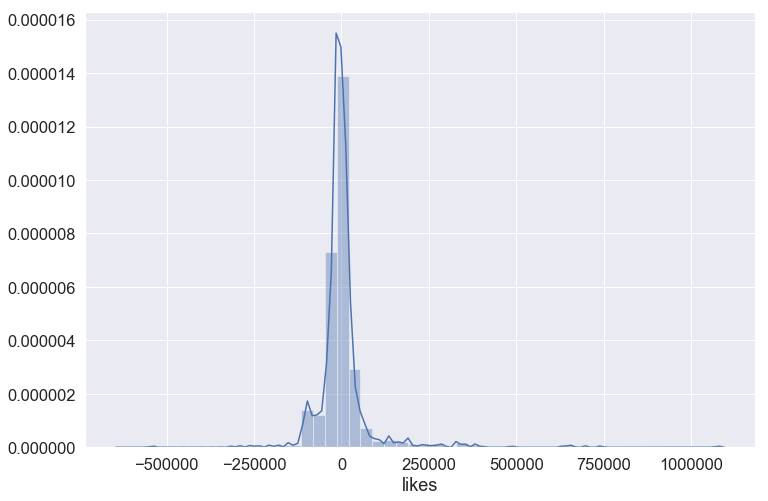

In [20]:
# residual histogram
plt.figure(figsize=(12, 8))
sns.distplot((y_test-y_pred), bins=50);

# Gradient Boosting regression with Grid Search

In [38]:
grad_boost_reg = GradientBoostingRegressor()

In [39]:
print('Optimizing parameters of gradient boosting regression...')
print('start at: {}'.format(datetime.now().time()))

parameters = {#'learning_rate': [0.1, 0.2, 0.3],
              'subsample': [0.9, 0.5, 0.2],
              'n_estimators': [50, 100, 150, 200],
              'max_depth': [3, 6, 8],
              'learning_rate': [0.1],# 0.05, 0.02, 0.01
              'alpha': [1e-15, 1e-10, 1e-5, 1e-3, 1e-2]}
grid = GridSearchCV(estimator=grad_boost_reg, param_grid=parameters, cv=5)
grid.fit(X_train, y_train)

print('stop at: {}'.format(datetime.now().time()))
print('---------------------------------')

print(grid.best_score_)
print(grid.best_estimator_)

Optimizing parameters of gradient boosting regression...
start at: 20:03:54.046067
stop at: 20:16:35.063570
---------------------------------
0.8684686233519329
GradientBoostingRegressor(alpha=0.01, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [40]:
y_pred = grid.predict(X_test)

Text(0, 0.5, 'Predicted Y')

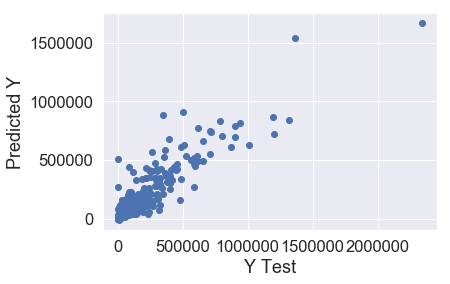

In [41]:
plt.scatter(y_test, y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [42]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared on training set: ', grid.score(X_train, y_train))
print('R squared on test set: ', grid.score(X_test, y_test))

MAE: 24933.88189376146
MSE: 3555169541.6781025
RMSE: 59625.2424873736
R squared on training set:  0.9919278673553646
R squared on test set:  0.8414529359189152


# Support Vector Regression with Grid Search

In [32]:
svr = SVR()

In [33]:
print('Optimizing parameters of support vector regression...')
print('start at: {}'.format(datetime.now().time()))

parameters = {'kernel': ('linear', 'rbf','poly'), 
              'C': [1e0, 1e1, 1e2, 1e3],
              'gamma': np.logspace(-2, 2, 5),
              'epsilon':[0.1, 0.3, 0.5]
             }
svr_regressor = GridSearchCV(estimator=svr, param_grid=parameters, cv=5, n_jobs=-1)
svr_regressor.fit(X_train, y_train)

print('stop at: {}'.format(datetime.now().time()))
print('---------------------------------')

print(svr_regressor.best_score_)
print(svr_regressor.best_estimator_)

Optimizing parameters of support vector regression...
start at: 17:39:30.654678


C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


stop at: 20:01:35.600947
---------------------------------
0.8217936983273878
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.5, gamma=100.0,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [34]:
y_pred = svr_regressor.predict(X_test)

Text(0, 0.5, 'Predicted Y')

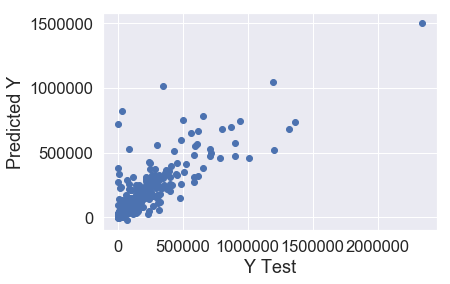

In [35]:
plt.scatter(y_test, y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [36]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared on training set: ', svr_regressor.score(X_train, y_train))
print('R squared on test set: ', svr_regressor.score(X_test, y_test))

MAE: 27675.906398582887
MSE: 5927838239.011764
RMSE: 76992.4557278943
R squared on training set:  0.9048262613483465
R squared on test set:  0.735640920039138


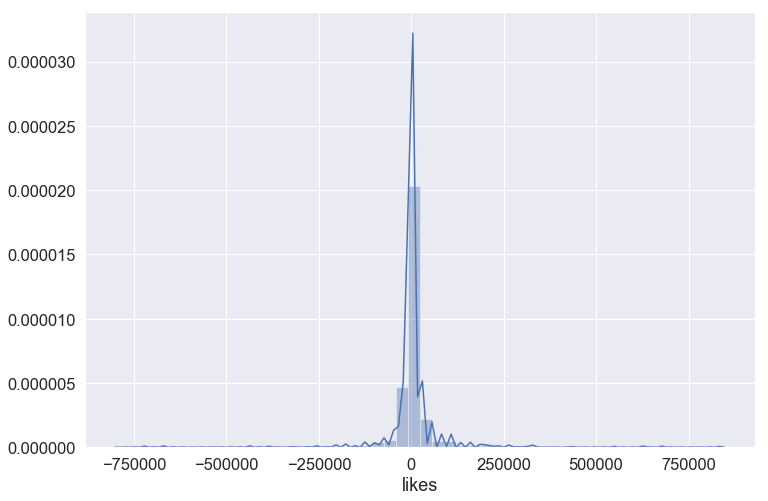

In [37]:
# residual histogram
plt.figure(figsize=(12, 8))
sns.distplot((y_test-y_pred), bins=50);

# Kernel Ridge Regression with Grid Search

In [21]:
kernel_ridge = KernelRidge()

In [22]:
print('Optimizing parameters of kernel ridge regression...')
print('start at: {}'.format(datetime.now().time()))

parameters = {'kernel': ('linear', 'rbf','poly'), 
              'alpha': [1e0, 0.1, 1e-2, 1e-3],
              'gamma': np.logspace(-2, 2, 5)}
krr_regressor = GridSearchCV(estimator=kernel_ridge, param_grid=parameters, cv=5)
krr_regressor.fit(X_train, y_train)

print('stop at: {}'.format(datetime.now().time()))
print('---------------------------------')

print(krr_regressor.best_score_)
print(krr_regressor.best_estimator_)

Optimizing parameters of kernel ridge regression...
start at: 16:59:44.571564


C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


stop at: 17:01:10.980448
---------------------------------
0.854528441629343
KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1, kernel='rbf',
            kernel_params=None)


In [23]:
y_pred = krr_regressor.predict(X_test)

Text(0, 0.5, 'Predicted Y')

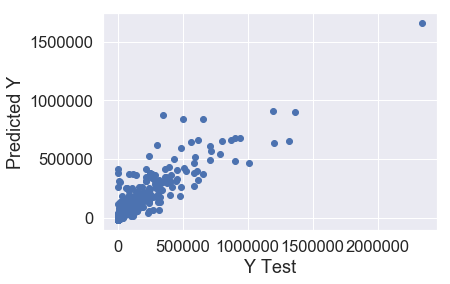

In [24]:
plt.scatter(y_test, y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [25]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared on training set: ', krr_regressor.score(X_train, y_train))
print('R squared on test set: ', krr_regressor.score(X_test, y_test))

MAE: 30090.9815111977
MSE: 4717423704.702227
RMSE: 68683.50387612899
R squared on training set:  0.8996532499925208
R squared on test set:  0.7896208128363931


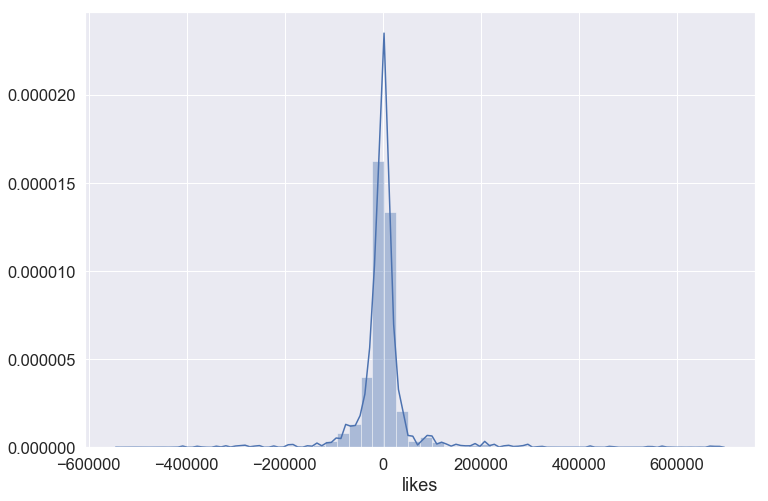

In [26]:
# residual histogram
plt.figure(figsize=(12, 8))
sns.distplot((y_test-y_pred), bins=50);

# Random Forest Regression with Grid Search

In [60]:
random_forest = RandomForestRegressor()

In [61]:
print('Optimizing parameters of random forest regression...')
print('start at: {}'.format(datetime.now().time()))

parameters = {'n_estimators': [140, 160, 180, 200, 220],
              'max_depth': [10, 15, 20]}
rand_forest_regressor = GridSearchCV(estimator=random_forest, param_grid=parameters, cv=5)
rand_forest_regressor.fit(X_train, y_train)

print('stop at: {}'.format(datetime.now().time()))
print('---------------------------------')

print(rand_forest_regressor.best_score_)
print(rand_forest_regressor.best_estimator_)

Optimizing parameters of random forest regression...
start at: 21:14:26.519264
stop at: 21:22:52.494691
---------------------------------
0.8535911216829155
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=220,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [62]:
y_pred = rand_forest_regressor.predict(X_test)

Text(0, 0.5, 'Predicted Y')

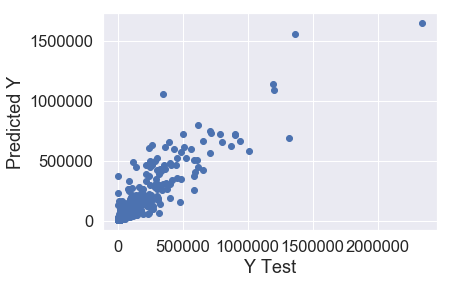

In [63]:
plt.scatter(y_test, y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [64]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared on training set: ', rand_forest_regressor.score(X_train, y_train))
print('R squared on test set: ', rand_forest_regressor.score(X_test, y_test))

MAE: 25940.874881232325
MSE: 3998623849.1548524
RMSE: 63234.67283978666
R squared on training set:  0.9795869437217358
R squared on test set:  0.8216765574142315


# AdaBoost Regressor

In [73]:
ada_boost = AdaBoostRegressor()

In [74]:
print('Optimizing parameters of ada boosting regression...')
print('start at: {}'.format(datetime.now().time()))

param_dist = {
     'n_estimators': [50, 100],
     'learning_rate' : [0.01, 0.05, 0.1, 0.3, 0.5, 1],
     'loss' : ['linear', 'square', 'exponential']
     }

ada_boost_regressor = RandomizedSearchCV(ada_boost, param_distributions=param_dist, cv=5, n_iter=10, n_jobs=4)

ada_boost_regressor.fit(X_train, y_train)

print('stop at: {}'.format(datetime.now().time()))
print('---------------------------------')

print(ada_boost_regressor.best_score_)
print(ada_boost_regressor.best_estimator_)

Optimizing parameters of ada boosting regression...
start at: 21:31:31.844050
stop at: 21:31:46.487456
---------------------------------
0.7799264051414001
AdaBoostRegressor(base_estimator=None, learning_rate=0.05, loss='square',
                  n_estimators=50, random_state=None)


In [75]:
y_pred = ada_boost_regressor.predict(X_test)

In [76]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared on training set: ', ada_boost_regressor.score(X_train, y_train))
print('R squared on test set: ', ada_boost_regressor.score(X_test, y_test))

MAE: 41022.34125321066
MSE: 6682003262.297459
RMSE: 81743.52122521674
R squared on training set:  0.890427602209885
R squared on test set:  0.7020080232467811
